In [1]:
import numpy as np
import pandas as pd 
from glob import glob
from os import path
import matplotlib.pyplot as plt
from torch.utils.data.dataset import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import preprocessing
from torch.autograd import Variable
import torch.utils.data as utils
from time import sleep
import tensorflow as tf
from statsmodels.tsa.arima_process import ArmaProcess
from sklearn.model_selection import train_test_split

/Users/shauryas/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [17]:
seed = 0
sequence_size = 10
np.random.seed(seed)
N = 10000
split_idx = int(N*0.8)

In [18]:
AR_object2 = ArmaProcess(np.array([1, -0.999]), np.array([1]))
y = AR_object2.generate_sample(nsample=N + sequence_size)
y = y.astype(np.float32)

In [19]:
y = np.sin(np.linspace(0,int(50*2*np.pi), N+sequence_size)).astype(np.float32)

In [20]:
X = np.expand_dims(y[:-sequence_size], -1)
y = np.expand_dims(y[sequence_size:], -1)


In [21]:
X_train = X[:split_idx]
y_train = y[:split_idx]
X_test = X[split_idx:]
y_test = y[split_idx:]

In [74]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64, stateful=True, batch_input_shape=(1,sequence_size,1)))
model.add(tf.keras.layers.Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [75]:

for _ in range(5):
    model.reset_states()
    train_acc = []
    for i in range(X_train.shape[0] - sequence_size):
        batch_data = np.expand_dims(X_train[i:i+sequence_size], 0)
        batch_label = y_train[i]
        loss, acc = model.train_on_batch(batch_data, batch_label)
        train_acc.append(acc)
    print('train acc {}'.format(np.mean(train_acc)))
        
    model.reset_states()
    test_acc = []
    for i in range(X_test.shape[0] - sequence_size):
        batch_data = np.expand_dims(X_test[i:i+sequence_size], 0)
        batch_label = y_test[i]
        loss, acc = model.test_on_batch(batch_data, batch_label)
        test_acc.append(acc)
    print('test acc {}'.format(np.mean(test_acc)))


train acc 0.0
test acc 0.0
train acc 0.0
test acc 0.0
train acc 0.0
test acc 0.0


KeyboardInterrupt: 

In [78]:
model.reset_states()
preds = []
for i in range(X_test.shape[0] - sequence_size):
    batch_data = np.expand_dims(X_test[i:i+sequence_size], 0)
    
    y_pred = model.predict_on_batch(batch_data)
    preds.append(y_pred)

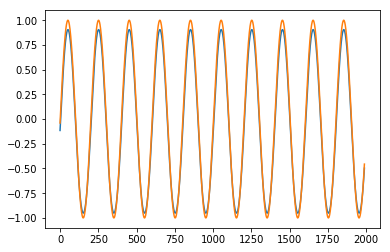

In [86]:
plt.plot(range(preds.shape[0]),preds, y_test[:-sequence_size])